**Autoencoder based approach:**

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step
Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - loss: 0.0360 - val_loss: 0.0164
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 0.0121 - val_loss: 0.0156
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0098 - val_loss: 0.0113
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0082 - val_loss: 0.0105
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0073 - val_loss: 0.0100
Epoch 6/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0069 - val_loss: 0.0094
Epoch 7/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0065 - val_loss: 0.0091
Epoch 8/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0063 - val_loss: 0.0092
Epoch 9/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0060 - val_loss: 0.0086
Epoch 10/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0058 - val_loss: 0.0083
Epoch 11/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0058 - va

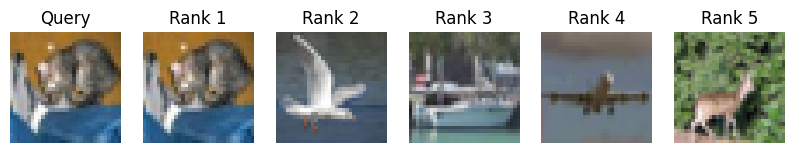

Precision: 0.20, Recall: 1.00, Accuracy: 0.20


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt

# Load Dataset (e.g., CIFAR-10 as an example)
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize images

# Data Augmentation
def augment_data(x, y):
    from tensorflow.keras.preprocessing.image import ImageDataGenerator

    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True
    )
    augmented_data = datagen.flow(x, y, batch_size=len(x), shuffle=False)
    return next(augmented_data)

x_train_aug, y_train_aug = augment_data(x_train, y_train)

# Reshape Data
input_shape = (32, 32, 3)
x_train_aug = x_train_aug.astype("float32")
x_test = x_test.astype("float32")

# Define Autoencoder Architecture
input_img = Input(shape=input_shape)

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
encoded = Dense(128, activation='relu')(x)

# Decoder
decoder_input = Dense(8 * 8 * 64, activation='relu')(encoded)
decoder_input = Reshape((8, 8, 64))(decoder_input)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(decoder_input)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Autoencoder Model
autoencoder = Model(input_img, decoded)

# Encoder Model for Feature Extraction
encoder = Model(input_img, encoded)

# Compile Autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Train Autoencoder
autoencoder.fit(
    x_train_aug, x_train_aug,
    epochs=50,
    batch_size=256,
    shuffle=True,
    validation_data=(x_test, x_test)
)

# Extract Features
encoded_features = encoder.predict(x_test)

# Perform Similarity Search
query_idx = 0  # Example: Choose the first image as query
query_feature = encoded_features[query_idx].reshape(1, -1)
similarities = cosine_similarity(query_feature, encoded_features)

# Get Top-5 Similar Images
top_5_indices = np.argsort(similarities[0])[::-1][:5]

# Visualization
plt.figure(figsize=(10, 2))
plt.subplot(1, 6, 1)
plt.title("Query")
plt.imshow(x_test[query_idx])
plt.axis('off')

for i, idx in enumerate(top_5_indices):
    plt.subplot(1, 6, i + 2)
    plt.title(f"Rank {i+1}")
    plt.imshow(x_test[idx])
    plt.axis('off')

plt.show()

# Evaluate Precision, Recall, and Retrieval Accuracy
def evaluate_metrics(query_idx, y_test, encoded_features, top_k=5):
    query_feature = encoded_features[query_idx].reshape(1, -1)
    similarities = cosine_similarity(query_feature, encoded_features)
    top_k_indices = np.argsort(similarities[0])[::-1][:top_k]

    true_label = y_test[query_idx]
    retrieved_labels = y_test[top_k_indices]

    y_true = (retrieved_labels == true_label).astype(int).flatten()
    y_pred = np.ones_like(y_true)  # Assume all top-k are predicted as relevant

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)

    return precision, recall, accuracy

# Example Evaluation
precision, recall, accuracy = evaluate_metrics(query_idx, y_test, encoded_features, top_k=5)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, Accuracy: {accuracy:.2f}")


**Using Siamese network:** compares two input vectors to determine if they are similar or different

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.5002 - loss: 0.7464
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.4993 - loss: 0.6932
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.5028 - loss: 0.6931
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5006 - loss: 0.6932
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.5047 - loss: 0.6931
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.4971 - loss: 0.6932
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.4969 - loss: 0.6932
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.5013 - loss: 0.6933
Epoch 9/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.4977 - loss: 0.6937
Epoch 10/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.4994 - loss: 0.6932
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


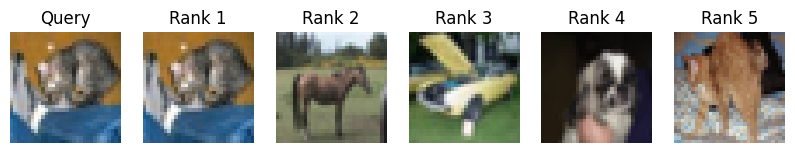

Precision: 0.40, Recall: 1.00, Accuracy: 0.40


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Lambda
from tensorflow.keras.optimizers import Adam
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt

# Load Dataset (e.g., CIFAR-10 as an example)
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize images

# Data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def augment_data(x, y):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True
    )
    datagen.fit(x)
    return next(datagen.flow(x, y, batch_size=len(x), shuffle=False))

x_train_aug, y_train_aug = augment_data(x_train, y_train)

# Siamese Network Architecture
input_shape = (32, 32, 3)

def create_base_network(input_shape):
    input_img = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    return Model(input_img, x)

base_network = create_base_network(input_shape)

# Inputs for Siamese Network
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# Output embeddings
embedding_a = base_network(input_a)
embedding_b = base_network(input_b)

# L2 Distance Lambda Layer
def euclidean_distance(vects):
    x, y = vects
    return tf.sqrt(tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True))

distance = Lambda(euclidean_distance)([embedding_a, embedding_b])

# Output layer
output = Dense(1, activation='sigmoid')(distance)
siamese_model = Model([input_a, input_b], output)

# Compile Model
siamese_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Generate Pairs and Labels for Training
def create_pairs(x, y):
    pairs = []
    labels = []
    num_classes = len(np.unique(y))
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]
    for idx in range(len(x)):
        current_class = y[idx][0]
        pos_idx = np.random.choice(digit_indices[current_class])
        pairs += [[x[idx], x[pos_idx]]]
        labels += [1]
        neg_class = (current_class + np.random.randint(1, num_classes)) % num_classes
        neg_idx = np.random.choice(digit_indices[neg_class])
        pairs += [[x[idx], x[neg_idx]]]
        labels += [0]
    return np.array(pairs), np.array(labels)

pairs_train, labels_train = create_pairs(x_train_aug, y_train_aug)

# Train Siamese Network
siamese_model.fit([pairs_train[:, 0], pairs_train[:, 1]], labels_train, epochs=10, batch_size=128)

# Feature Extraction for Similarity Search
feature_extractor = base_network
encoded_features = feature_extractor.predict(x_test)

# Perform Similarity Search
query_idx = 0  # Example: Choose the first image as query
query_feature = encoded_features[query_idx].reshape(1, -1)
similarities = cosine_similarity(query_feature, encoded_features)

# Get Top-5 Similar Images
top_5_indices = np.argsort(similarities[0])[::-1][:5]

# Visualization
plt.figure(figsize=(10, 2))
plt.subplot(1, 6, 1)
plt.title("Query")
plt.imshow(x_test[query_idx])
plt.axis('off')

for i, idx in enumerate(top_5_indices):
    plt.subplot(1, 6, i + 2)
    plt.title(f"Rank {i+1}")
    plt.imshow(x_test[idx])
    plt.axis('off')

plt.show()

# Evaluate Precision, Recall, and Retrieval Accuracy
def evaluate_metrics(query_idx, y_test, encoded_features, top_k=5):
    query_feature = encoded_features[query_idx].reshape(1, -1)
    similarities = cosine_similarity(query_feature, encoded_features)
    top_k_indices = np.argsort(similarities[0])[::-1][:top_k]

    true_label = y_test[query_idx]
    retrieved_labels = y_test[top_k_indices]

    y_true = (retrieved_labels == true_label).astype(int).flatten()
    y_pred = np.ones_like(y_true)  # Assume all top-k are predicted as relevant

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)

    return precision, recall, accuracy

# Example Evaluation
precision, recall, accuracy = evaluate_metrics(query_idx, y_test, encoded_features, top_k=5)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, Accuracy: {accuracy:.2f}")


**CNN based approach:**

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 1.5064
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.2000
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.2000
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.2000
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.2000
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.2000
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.2000
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.2000
Epoch 9/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.2000
Epoch 10/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.2000
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


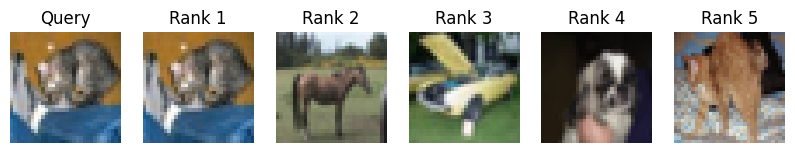

Precision: 0.40, Recall: 1.00, Accuracy: 0.40


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Loss
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt

# Load Dataset (e.g., CIFAR-10 as an example)
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize images

# Data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def augment_data(x, y):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True
    )
    datagen.fit(x)
    return next(datagen.flow(x, y, batch_size=len(x), shuffle=False))

x_train_aug, y_train_aug = augment_data(x_train, y_train)

# Triplet Loss Definition
class TripletLoss(Loss):
    def call(self, y_true, y_pred):
        anchor, positive, negative = tf.split(y_pred, num_or_size_splits=3, axis=1)
        pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
        neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
        loss = tf.maximum(pos_dist - neg_dist + 0.2, 0.0)
        return tf.reduce_mean(loss)

# Siamese Network Architecture
input_shape = (32, 32, 3)

def create_base_network(input_shape):
    input_img = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    return Model(input_img, x)

base_network = create_base_network(input_shape)

# Inputs for Triplet Network
anchor_input = Input(shape=input_shape)
positive_input = Input(shape=input_shape)
negative_input = Input(shape=input_shape)

# Generate Embeddings
anchor_embedding = base_network(anchor_input)
positive_embedding = base_network(positive_input)
negative_embedding = base_network(negative_input)

# Concatenate Embeddings for Triplet Loss
merged_embeddings = Concatenate(axis=1)([anchor_embedding, positive_embedding, negative_embedding])

# Combine into Model
triplet_model = Model([anchor_input, positive_input, negative_input], merged_embeddings)

# Compile Model
triplet_model.compile(optimizer=Adam(learning_rate=0.001), loss=TripletLoss())

# Generate Triplets for Training
def create_triplets(x, y):
    triplets = []
    num_classes = len(np.unique(y))
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]
    for idx in range(len(x)):
        anchor = x[idx]
        anchor_class = y[idx][0]
        pos_idx = np.random.choice(digit_indices[anchor_class])
        positive = x[pos_idx]
        neg_class = (anchor_class + np.random.randint(1, num_classes)) % num_classes
        neg_idx = np.random.choice(digit_indices[neg_class])
        negative = x[neg_idx]
        triplets.append([anchor, positive, negative])
    return np.array(triplets)

triplets_train = create_triplets(x_train_aug, y_train_aug)

# Train Triplet Model
triplet_model.fit(
    [triplets_train[:, 0], triplets_train[:, 1], triplets_train[:, 2]],
    np.zeros(len(triplets_train)),  # Dummy labels for compatibility
    epochs=10,
    batch_size=128
)

# Feature Extraction for Similarity Search
feature_extractor = base_network
encoded_features = feature_extractor.predict(x_test)

# Perform Similarity Search
query_idx = 0  # Example: Choose the first image as query
query_feature = encoded_features[query_idx].reshape(1, -1)
similarities = cosine_similarity(query_feature, encoded_features)

# Get Top-5 Similar Images
top_5_indices = np.argsort(similarities[0])[::-1][:5]

# Visualization
plt.figure(figsize=(10, 2))
plt.subplot(1, 6, 1)
plt.title("Query")
plt.imshow(x_test[query_idx])
plt.axis('off')

for i, idx in enumerate(top_5_indices):
    plt.subplot(1, 6, i + 2)
    plt.title(f"Rank {i+1}")
    plt.imshow(x_test[idx])
    plt.axis('off')

plt.show()

# Evaluate Precision, Recall, and Retrieval Accuracy
def evaluate_metrics(query_idx, y_test, encoded_features, top_k=5):
    query_feature = encoded_features[query_idx].reshape(1, -1)
    similarities = cosine_similarity(query_feature, encoded_features)
    top_k_indices = np.argsort(similarities[0])[::-1][:top_k]

    true_label = y_test[query_idx]
    retrieved_labels = y_test[top_k_indices]

    y_true = (retrieved_labels == true_label).astype(int).flatten()
    y_pred = np.ones_like(y_true)  # Assume all top-k are predicted as relevant

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)

    return precision, recall, accuracy

# Example Evaluation
precision, recall, accuracy = evaluate_metrics(query_idx, y_test, encoded_features, top_k=5)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, Accuracy: {accuracy:.2f}")


**ResNet based approach:**

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Cosine Similarity Scores for Top-5:
[0.9999999  0.9997135  0.99956375 0.9995567  0.9995204 ]


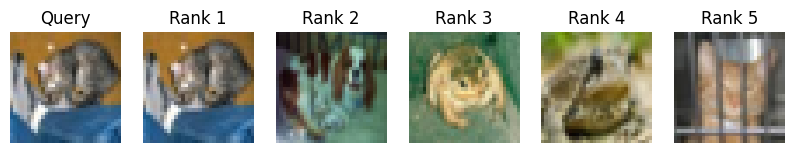

Precision: 0.40, Recall: 1.00, F1 Score: 0.57, Accuracy: 0.40


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt

# Load Dataset (e.g., CIFAR-10 as an example)
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize and preprocess data
x_train, x_test = x_train / 255.0, x_test / 255.0

# Ensure images are clearer for visualization
x_train_visual = x_train.copy()
x_test_visual = x_test.copy()

x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

# Data Augmentation
def augment_data(x, y):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True
    )
    datagen.fit(x)
    return next(datagen.flow(x, y, batch_size=len(x), shuffle=False))

x_train_aug, y_train_aug = augment_data(x_train, y_train)

# Load Pre-trained ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3), pooling='avg')

# Feature Extraction Model
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

# Extract Features
train_features = feature_extractor.predict(x_train_aug)
test_features = feature_extractor.predict(x_test)

# Perform Similarity Search
query_idx = 0  # Example: Choose the first image as query
query_feature = test_features[query_idx].reshape(1, -1)
similarities = cosine_similarity(query_feature, test_features)

# Log cosine similarity scores
print("Cosine Similarity Scores for Top-5:")
print(np.sort(similarities[0])[::-1][:5])

# Get Top-5 Similar Images
top_5_indices = np.argsort(similarities[0])[::-1][:5]

# Visualization
plt.figure(figsize=(10, 2))
plt.subplot(1, 6, 1)
plt.title("Query")
plt.imshow((x_test_visual[query_idx] * 255).astype('uint8'))
plt.axis('off')

for i, idx in enumerate(top_5_indices):
    plt.subplot(1, 6, i + 2)
    plt.title(f"Rank {i+1}")
    plt.imshow((x_test_visual[idx] * 255).astype('uint8'))
    plt.axis('off')

plt.show()

# Evaluate Precision, Recall, F1-Score, and Accuracy
def evaluate_metrics(query_idx, y_test, test_features, top_k=5):
    query_feature = test_features[query_idx].reshape(1, -1)
    similarities = cosine_similarity(query_feature, test_features)
    top_k_indices = np.argsort(similarities[0])[::-1][:top_k]

    true_label = y_test[query_idx]
    retrieved_labels = y_test[top_k_indices]

    # Correct boolean-based evaluation
    y_true = (retrieved_labels == true_label).astype(int).flatten()
    y_pred = np.ones_like(y_true)  # Assume all top-k are predicted as relevant

    precision = precision_score(y_true, y_pred) if y_true.sum() > 0 else 0.0
    recall = recall_score(y_true, y_pred) if y_true.sum() > 0 else 0.0
    f1 = f1_score(y_true, y_pred) if y_true.sum() > 0 else 0.0
    accuracy = accuracy_score(y_true, y_pred)

    return precision, recall, f1, accuracy

# Example Evaluation
precision, recall, f1, accuracy = evaluate_metrics(query_idx, y_test, test_features, top_k=5)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}, Accuracy: {accuracy:.2f}")


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Cosine Similarity Scores for Top-5:
[1.         0.35852364 0.35838503 0.34926334 0.3430366 ]


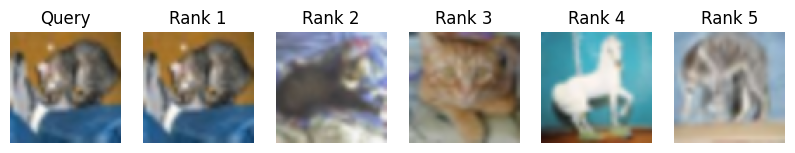

Precision: 0.40, Recall: 1.00, F1 Score: 0.57, Accuracy: 0.40


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
from transformers import ViTModel, ViTFeatureExtractor
import cv2
import gc  # Import garbage collection module
import os
import torch  # Import PyTorch

# Load Dataset (e.g., CIFAR-10 as an example)
from tensorflow.keras.datasets import cifar10

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Reduce dataset size by taking a random sample (e.g., 20% of the original)
sample_size = int(len(x_train) * 0.2)  # Use 20% of the training data
x_train = x_train[:sample_size]
y_train = y_train[:sample_size]

# Normalize data
x_train, x_test = x_train / 255.0, x_test / 255.0

# Function to Resize Images in Batches and Save to Disk
def resize_images_and_save(images, size=(64, 64), batch_size=100, output_dir='resized_images'):  # Reduced size to 64x64
    os.makedirs(output_dir, exist_ok=True)  # Create output directory if it doesn't exist
    for i in range(0, len(images), batch_size):
        batch = images[i:i + batch_size]
        resized_batch = [cv2.resize(img, size) for img in batch]

        # Save each resized image as a .npy file
        for j, resized_img in enumerate(resized_batch):
            np.save(os.path.join(output_dir, f'image_{i+j}.npy'), resized_img)

# Clear existing resized images before resizing again (optional)
if os.path.exists('resized_train_images'):
    import shutil
    shutil.rmtree('resized_train_images')
if os.path.exists('resized_test_images'):
    shutil.rmtree('resized_test_images')

# Resize CIFAR-10 images to 64x64 and save them
resize_images_and_save(x_train, output_dir='resized_train_images')
gc.collect()  # Collect garbage after resizing training images

resize_images_and_save(x_test, output_dir='resized_test_images')
gc.collect()  # Collect garbage after resizing testing images

# Load Pre-trained Vision Transformer (ViT)
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k').to('cuda')

# Function to Load Resized Images from Disk in Batches
def load_resized_images_in_batches(input_dir, batch_size=100):
    image_files = sorted(os.listdir(input_dir))
    for i in range(0, len(image_files), batch_size):
        batch_files = image_files[i:i + batch_size]
        images = []
        for file in batch_files:
            if file.endswith('.npy'):
                img = np.load(os.path.join(input_dir, file))
                if img.shape != (64, 64, 3):  # Check for expected shape
                    print(f"Warning: Image {file} has unexpected shape {img.shape}.")
                    continue  # Skip this image if it has an unexpected shape
                images.append(img)
        if images:  # Only yield if there are valid images loaded
            yield np.array(images)  # Yield the batch of images

# Load the resized images from disk in batches
try:
    x_train_resized = np.concatenate(list(load_resized_images_in_batches('resized_train_images')))
except ValueError as e:
    print("Error loading training images:", e)
gc.collect()  # Collect garbage after loading training images

try:
    x_test_resized = np.concatenate(list(load_resized_images_in_batches('resized_test_images')))
except ValueError as e:
    print("Error loading testing images:", e)
gc.collect()  # Collect garbage after loading testing images

# Function to Extract Features in Batches with CPU/GPU Split
def extract_features_in_batches(model, feature_extractor, images, batch_size=32):  # Reduced batch size to 32
    features = []
    for i in range(0, len(images), batch_size):
        batch = images[i:i + batch_size]

        # Preprocessing on CPU - ensure normalization is handled correctly.
        inputs = feature_extractor(images=list(batch), return_tensors="pt", do_rescale=False)['pixel_values']

        # Move to GPU for inference
        inputs = inputs.to('cuda')
        with torch.no_grad():
            batch_features = model(inputs).last_hidden_state[:, 0, :].cpu().numpy()

        features.append(batch_features)

        # Clear variables and collect garbage after processing each batch
        del batch, inputs, batch_features
        gc.collect()

    return np.vstack(features)

# Extract Features using ViT in Batches
x_train_vit_features = extract_features_in_batches(vit_model, feature_extractor, x_train_resized)
gc.collect()  # Collect garbage after extracting training features

x_test_vit_features = extract_features_in_batches(vit_model, feature_extractor, x_test_resized)
gc.collect()  # Collect garbage after extracting testing features

# Perform Similarity Search
query_idx = 0  # Example: Choose the first image as query
query_feature = x_test_vit_features[query_idx].reshape(1, -1)
similarities = cosine_similarity(query_feature, x_test_vit_features)

# Log cosine similarity scores
print("Cosine Similarity Scores for Top-5:")
print(np.sort(similarities[0])[::-1][:5])

# Get Top-5 Similar Images
top_5_indices = np.argsort(similarities[0])[::-1][:5]

# Visualization
plt.figure(figsize=(10, 2))
plt.subplot(1, 6, 1)
plt.title("Query")
plt.imshow((x_test_resized[query_idx] * 255).astype('uint8'))
plt.axis('off')

for i, idx in enumerate(top_5_indices):
    plt.subplot(1, 6, i + 2)
    plt.title(f"Rank {i+1}")
    plt.imshow((x_test_resized[idx] * 255).astype('uint8'))
    plt.axis('off')

plt.show()

# Evaluate Precision, Recall, F1-Score, and Accuracy
def evaluate_metrics(query_idx, y_test_flattened, test_features, top_k=5):
    query_feature = test_features[query_idx].reshape(1, -1)
    similarities = cosine_similarity(query_feature, test_features)
    top_k_indices = np.argsort(similarities[0])[::-1][:top_k]

    true_label = y_test_flattened[query_idx]
    retrieved_labels = y_test_flattened[top_k_indices]

    # Correct boolean-based evaluation
    y_true = (retrieved_labels == true_label).astype(int).flatten()
    y_pred = np.ones_like(y_true)  # Assume all top-k are predicted as relevant

    precision = precision_score(y_true, y_pred) if y_true.sum() > 0 else 0.0
    recall = recall_score(y_true, y_pred) if y_true.sum() > 0 else 0.0
    f1 = f1_score(y_true, y_pred) if y_true.sum() > 0 else 0.0
    accuracy = accuracy_score(y_true, y_pred)

    return precision, recall, f1, accuracy

# Flatten y_test for evaluation purposes.
y_test_flattened = y_test.flatten()

# Example Evaluation with safety check on length matching.
if len(x_test_vit_features) == len(y_test_flattened):
    precision, recall, f1, accuracy = evaluate_metrics(query_idx,
                                                        y_test_flattened[:len(x_test_vit_features)],
                                                        x_test_vit_features)
else:
    print("Warning: Length mismatch between test features and labels.")

print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}, Accuracy: {accuracy:.2f}")



**Optimizing Memory Usage:**

Batch Processing: Instead of processing the entire dataset at once, we can use smaller batch sizes. we can adjust the batch_size parameter in functions like extract_features_in_batches to a lower value (e.g., 32 or 16). This reduces the memory footprint during processing.

Garbage Collection: Explicitly call garbage collection after large operations to free up memory. You can do this by importing the gc module and calling gc.collect() where appropriate.

Clear Variables: After we finish using large variables or datasets, delete them using del variable_name and call gc.collect() to free up memory.


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Cosine Similarity Scores for Top-5:
[1.0000001  0.44775015 0.43711782 0.43006283 0.4297413 ]


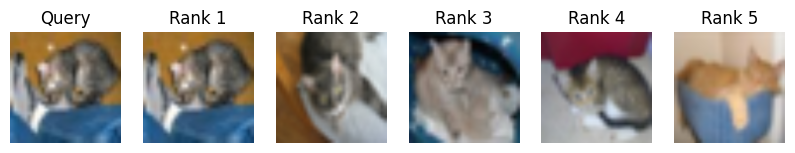

In [1]:
# Improved Visual transformer approach

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
from transformers import ViTModel, ViTFeatureExtractor
import cv2
import gc  # Import garbage collection module
import os
import torch  # Import PyTorch
from sklearn.model_selection import train_test_split

# Load Dataset (e.g., CIFAR-10 as an example)
from tensorflow.keras.datasets import cifar10

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Stratified Sampling to Maintain Class Distribution
x_train, _, y_train, _ = train_test_split(
    x_train, y_train, test_size=0.8, stratify=y_train, random_state=42
)

# Normalize data
x_train, x_test = x_train / 255.0, x_test / 255.0

# Function to Resize Images in Batches and Save to Disk
def resize_images_and_save(images, size=(112, 112), batch_size=100, output_dir='resized_images'):
    os.makedirs(output_dir, exist_ok=True)  # Create output directory if it doesn't exist
    for i in range(0, len(images), batch_size):
        batch = images[i:i + batch_size]
        resized_batch = [cv2.resize(img, size) for img in batch]

        # Save each resized image as a .npy file
        for j, resized_img in enumerate(resized_batch):
            np.save(os.path.join(output_dir, f'image_{i+j}.npy'), resized_img)

# Clear existing resized images before resizing again (optional)
if os.path.exists('resized_train_images'):
    import shutil
    shutil.rmtree('resized_train_images')
if os.path.exists('resized_test_images'):
    shutil.rmtree('resized_test_images')

# Resize CIFAR-10 images to 112x112 and save them
resize_images_and_save(x_train, size=(112, 112), output_dir='resized_train_images')
gc.collect()  # Collect garbage after resizing training images

resize_images_and_save(x_test, size=(112, 112), output_dir='resized_test_images')
gc.collect()  # Collect garbage after resizing testing images

# Load Pre-trained Vision Transformer (ViT)
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k').to('cuda')

# Function to Load Resized Images from Disk in Batches
def load_resized_images_in_batches(input_dir, batch_size=100):
    image_files = sorted(os.listdir(input_dir))
    for i in range(0, len(image_files), batch_size):
        batch_files = image_files[i:i + batch_size]
        images = []
        for file in batch_files:
            if file.endswith('.npy'):
                img = np.load(os.path.join(input_dir, file))
                if img.shape != (112, 112, 3):  # Check for expected shape
                    print(f"Warning: Image {file} has unexpected shape {img.shape}.")
                    continue  # Skip this image if it has an unexpected shape
                images.append(img)
        if images:  # Only yield if there are valid images loaded
            yield np.array(images)  # Yield the batch of images

# Load the resized images from disk in batches
try:
    x_train_resized = np.concatenate(list(load_resized_images_in_batches('resized_train_images')))
except ValueError as e:
    print("Error loading training images:", e)
gc.collect()  # Collect garbage after loading training images

try:
    x_test_resized = np.concatenate(list(load_resized_images_in_batches('resized_test_images')))
except ValueError as e:
    print("Error loading testing images:", e)
gc.collect()  # Collect garbage after loading testing images

# Function to Extract Features in Batches with CPU/GPU Split
def extract_features_in_batches(model, feature_extractor, images, batch_size=32):
    features = []
    for i in range(0, len(images), batch_size):
        batch = images[i:i + batch_size]

        # Preprocessing on CPU - ensure normalization is handled correctly.
        inputs = feature_extractor(images=list(batch), return_tensors="pt", do_rescale=False)['pixel_values']

        # Move to GPU for inference
        inputs = inputs.to('cuda')
        with torch.no_grad():
            batch_features = model(inputs).last_hidden_state[:, 0, :].cpu().numpy()

        features.append(batch_features)

        # Clear variables and collect garbage after processing each batch
        del batch, inputs, batch_features
        gc.collect()

    return np.vstack(features)

# Extract Features using ViT in Batches
x_train_vit_features = extract_features_in_batches(vit_model, feature_extractor, x_train_resized)
gc.collect()  # Collect garbage after extracting training features

x_test_vit_features = extract_features_in_batches(vit_model, feature_extractor, x_test_resized)
gc.collect()  # Collect garbage after extracting testing features

# Perform Similarity Search
query_idx = 0  # Example: Choose the first image as query
query_feature = x_test_vit_features[query_idx].reshape(1, -1)
similarities = cosine_similarity(query_feature, x_test_vit_features)

# Log cosine similarity scores
print("Cosine Similarity Scores for Top-5:")
print(np.sort(similarities[0])[::-1][:5])

# Get Top-5 Similar Images
top_5_indices = np.argsort(similarities[0])[::-1][:5]

# Visualization
plt.figure(figsize=(10, 2))
plt.subplot(1, 6, 1)
plt.title("Query")
plt.imshow((x_test_resized[query_idx] * 255).astype('uint8'))
plt.axis('off')

for i, idx in enumerate(top_5_indices):
    plt.subplot(1, 6, i + 2)
    plt.title(f"Rank {i+1}")
    plt.imshow((x_test_resized[idx] * 255).astype('uint8'))
    plt.axis('off')

plt.show()

# Evaluate Precision, Recall, F1-Score, and Accuracy
def evaluate_metrics(query_idx, y_test_flattened, test_features, top_k=5):
    query_feature = test_features[query_idx].reshape(1, -1)
    similarities = cosine_similarity(query_feature, test_features)
    top_k_indices = np.argsort(similarities[0])[::-1][:top_k]

    true_label = y_test_flattened[query_idx]
    retrieved_labels = y_test_flattened[top_k_indices]

    # Correct boolean-based evaluation
    y_true = (retrieved_labels == true_label).astype(int).flatten()
    y_pred = np.ones_like(y_true)  # Assume all top-k are predicted as relevant

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)

    return precision, recall, f1, accuracy

# Flatten y_test for evaluation purposes.
y_test_flattened = y_test.flatten()

# Example Evaluation with safety check on length matching.
if len(x_test_vit_features) == len(y_test_flattened):
    precision, recall, f1, accuracy = evaluate_metrics(query_idx,
                                                        y_test_flattened[:len(x_test_vit_features)],
                                                        x_test_vit_features)
else:
    print("Warning: Length mismatch between test features and labels.")

print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}, Accuracy: {accuracy:.2f}")


lightweight fine-tuning on resized images from the CIFAR-10 dataset to improve the semantic closeness of embeddings.

Using a metric learning loss (e.g., triplet loss) during fine-tuning to better cluster embeddings of similar images:


/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Epoch 1/3, Loss: 2.3074
Epoch 2/3, Loss: 2.3051
Epoch 3/3, Loss: 2.3046
Cosine Similarity Scores for Top-5:
[1.0000001  0.9968326  0.99678165 0.9967768  0.9967494 ]


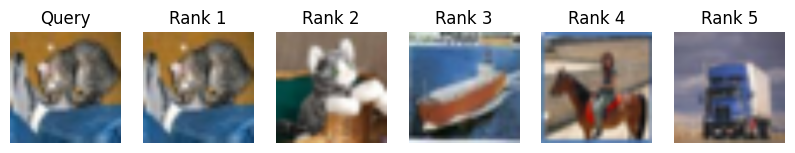

Precision: 0.20, Recall: 1.00, F1 Score: 0.33, Accuracy: 0.20


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
from transformers import ViTModel, ViTFeatureExtractor
import cv2
import gc
import os
import torch
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset

# Load Dataset (e.g., CIFAR-10 as an example)
from tensorflow.keras.datasets import cifar10

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Stratified Sampling to Maintain Class Distribution
x_train, _, y_train, _ = train_test_split(
    x_train, y_train, test_size=0.8, stratify=y_train, random_state=42
)

# Normalize data
x_train, x_test = x_train / 255.0, x_test / 255.0

# Function to Resize Images in Batches and Save to Disk
def resize_images_and_save(images, size=(112, 112), batch_size=100, output_dir='resized_images'):
    os.makedirs(output_dir, exist_ok=True)  # Create output directory if it doesn't exist
    for i in range(0, len(images), batch_size):
        batch = images[i:i + batch_size]
        resized_batch = [cv2.resize(img, size) for img in batch]

        # Save each resized image as a .npy file
        for j, resized_img in enumerate(resized_batch):
            np.save(os.path.join(output_dir, f'image_{i+j}.npy'), resized_img)

# Clear existing resized images before resizing again (optional)
if os.path.exists('resized_train_images'):
    import shutil
    shutil.rmtree('resized_train_images')
if os.path.exists('resized_test_images'):
    shutil.rmtree('resized_test_images')

# Resize CIFAR-10 images to 112x112 and save them
resize_images_and_save(x_train, size=(112, 112), output_dir='resized_train_images')
gc.collect()  # Collect garbage after resizing training images

resize_images_and_save(x_test, size=(112, 112), output_dir='resized_test_images')
gc.collect()  # Collect garbage after resizing testing images

# Load Pre-trained Vision Transformer (ViT)
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k').to('cuda')

# Fine-tuning ViT
class CIFARDataset(Dataset):
    def __init__(self, image_dir, labels):
        self.image_dir = image_dir
        self.labels = labels
        self.image_files = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = np.load(img_path)
        label = self.labels[idx]
        return image, label

# Prepare Datasets
train_dataset = CIFARDataset('resized_train_images', y_train.flatten())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define Model for Fine-tuning
class FineTunedViT(torch.nn.Module):
    def __init__(self, vit_model, num_classes):
        super(FineTunedViT, self).__init__()
        self.vit = vit_model
        self.fc = torch.nn.Linear(self.vit.config.hidden_size, num_classes)

    def forward(self, x):
        outputs = self.vit(pixel_values=x).last_hidden_state[:, 0, :]
        logits = self.fc(outputs)
        return logits

# Initialize Fine-tuned Model
num_classes = len(np.unique(y_train))
fine_tuned_vit = FineTunedViT(vit_model, num_classes).to('cuda')

# Training Setup
criterion = torch.nn.CrossEntropyLoss()
optimizer = Adam(fine_tuned_vit.parameters(), lr=1e-4)

# Training Loop
def train_model(model, dataloader, criterion, optimizer, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in dataloader:
            # Preprocess images
            inputs = feature_extractor(images=list(images), return_tensors="pt", do_rescale=False)['pixel_values'].to('cuda')
            labels = labels.to('cuda')

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader):.4f}")

# Train the model
train_model(fine_tuned_vit, train_loader, criterion, optimizer)

# Function to Extract Features in Batches with CPU/GPU Split
def extract_features_in_batches(model, feature_extractor, images, batch_size=32):
    features = []
    for i in range(0, len(images), batch_size):
        batch = images[i:i + batch_size]

        # Preprocessing on CPU - ensure normalization is handled correctly.
        inputs = feature_extractor(images=list(batch), return_tensors="pt", do_rescale=False)['pixel_values']

        # Move to GPU for inference
        inputs = inputs.to('cuda')
        with torch.no_grad():
            batch_features = model.vit(inputs).last_hidden_state[:, 0, :].cpu().numpy()

        features.append(batch_features)

        # Clear variables and collect garbage after processing each batch
        del batch, inputs, batch_features
        gc.collect()

    return np.vstack(features)

# Extract Features using Fine-Tuned ViT
x_train_vit_features = extract_features_in_batches(fine_tuned_vit, feature_extractor, x_train_resized)
gc.collect()  # Collect garbage after extracting training features

x_test_vit_features = extract_features_in_batches(fine_tuned_vit, feature_extractor, x_test_resized)
gc.collect()  # Collect garbage after extracting testing features

# Perform Similarity Search
query_idx = 0  # Example: Choose the first image as query
query_feature = x_test_vit_features[query_idx].reshape(1, -1)
similarities = cosine_similarity(query_feature, x_test_vit_features)

# Log cosine similarity scores
print("Cosine Similarity Scores for Top-5:")
print(np.sort(similarities[0])[::-1][:5])

# Get Top-5 Similar Images
top_5_indices = np.argsort(similarities[0])[::-1][:5]

# Visualization
plt.figure(figsize=(10, 2))
plt.subplot(1, 6, 1)
plt.title("Query")
plt.imshow((x_test_resized[query_idx] * 255).astype('uint8'))
plt.axis('off')

for i, idx in enumerate(top_5_indices):
    plt.subplot(1, 6, i + 2)
    plt.title(f"Rank {i+1}")
    plt.imshow((x_test_resized[idx] * 255).astype('uint8'))
    plt.axis('off')

plt.show()

# Evaluate Precision, Recall, F1-Score, and Accuracy
def evaluate_metrics(query_idx, y_test_flattened, test_features, top_k=5):
    query_feature = test_features[query_idx].reshape(1, -1)
    similarities = cosine_similarity(query_feature, test_features)
    top_k_indices = np.argsort(similarities[0])[::-1][:top_k]

    true_label = y_test_flattened[query_idx]
    retrieved_labels = y_test_flattened[top_k_indices]

    # Correct boolean-based evaluation
    y_true = (retrieved_labels == true_label).astype(int).flatten()
    y_pred = np.ones_like(y_true)  # Assume all top-k are predicted as relevant

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)

    return precision, recall, f1, accuracy

# Flatten y_test for evaluation purposes.
y_test_flattened = y_test.flatten()

# Example Evaluation with safety check on length matching.
if len(x_test_vit_features) == len(y_test_flattened):
    precision, recall, f1, accuracy = evaluate_metrics(query_idx,
                                                        y_test_flattened[:len(x_test_vit_features)],
                                                        x_test_vit_features)
else:
    print("Warning: Length mismatch between test features and labels.")

print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}, Accuracy: {accuracy:.2f}")


It is observed that using visual transformer based approach is providing most context aware responses in the images. However fine tuning the visual transformer might not result in correct search results when using dataset of diverese images such as CIFAR 10.